## Data uplodings

In [0]:
# Reload utils to ensure we have the latest version
import utils
import importlib
importlib.reload(utils) # forces the system to load the updated version
from utils import *

BRONZE_DIR = "/FileStore/tables/paris_project/bronze"

### Data Uploading

In [0]:
# config
storage_account = "lab94290"  
container = "airbnb"

sas_token= "<enter sas_token here from the report's appendix>"
if sas_token == "<enter sas_token here from the report's appendix>":
    raise Exception("Please fill in your sas token!")

sas_token = sas_token.lstrip('?')
spark.conf.set(f"fs.azure.account.auth.type.{storage_account}.dfs.core.windows.net", "SAS")
spark.conf.set(f"fs.azure.sas.token.provider.type.{storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
spark.conf.set(f"fs.azure.sas.fixed.token.{storage_account}.dfs.core.windows.net", sas_token)

In [0]:
path = f"abfss://{container}@{storage_account}.dfs.core.windows.net/airbnb_1_12_parquet"
global_df = spark.read.parquet(path)

In [0]:
%skip
save_data_set(global_df, base_path=BRONZE_DIR, num_pages=8, save_path="global_org_df.parquet")

In [0]:
storage_account = "lab94290"  
blob_sas_token = "<enter blob_sas_token here from the report's appendix>"
if blob_sas_token == "<enter blob_sas_token here from the report's appendix>":
    raise Exception("Please fill in your blob sas token!")
spark.conf.set(
    f"fs.azure.sas.submissions.{storage_account}.blob.core.windows.net",
    blob_sas_token
)
path = "wasbs://submissions@lab94290.blob.core.windows.net/Ron_Aviv_Naomi/bronze" 

In [0]:

paris_df = spark.read.csv(
    f"{path}/local_org_df.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)
#display(paris_df.limit(5))

paris_monuments = spark.read.csv(
    f"{path}/paris_monuments_org.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)

paris_metro = spark.read.csv(
    f"{path}/paris_metros_org.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)

In [0]:
%skip
save_data_set(paris_df, base_path=BRONZE_DIR, num_pages=2, save_path="local_org_df.parquet")

In [0]:
save_data_set(paris_monuments, base_path=BRONZE_DIR, num_pages=1, save_path="paris_monuments_org.parquet")
save_data_set(paris_metro, base_path=BRONZE_DIR, num_pages=1, save_path="paris_metros_org.parquet")

Saving data set to to /FileStore/tables/paris_project/bronze/paris_monuments_org.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/bronze/paris_monuments_org.parquet.
Saving data set to to /FileStore/tables/paris_project/bronze/paris_metros_org.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/bronze/paris_metros_org.parquet.


## Comparing Data From 2 Sources

In [0]:
import regex as re 
import pyspark.sql.functions as F
paris_from_global = global_df.filter(F.lower(global_df.location).rlike(r"^paris"))

paris_from_global.cache()
paris_listing_in_global_df = paris_from_global.count()
print(f"from the given global air bnb dataset, there are {paris_listing_in_global_df} listings in Paris")
#display(paris_from_global.limit(5))

from the given global air bnb dataset, there are 14933 listings in Paris


In [0]:
# the schema is different. the paris data is reacher.
# some of the columns probably have same data, but different naming. some might be vise versa
print(f"global df cols: {sorted(paris_from_global.columns)}\n")
print(f"paris df cols: {sorted(paris_df.columns)}")

global df cols: ['amenities', 'arrangement_details', 'availability', 'available_dates', 'breadcrumbs', 'cancellation_policy', 'category', 'category_rating', 'country', 'currency', 'description', 'description_by_sections', 'description_html', 'description_items', 'details', 'discount', 'final_url', 'guests', 'highlights', 'host_details', 'host_image', 'host_number_of_reviews', 'host_rating', 'host_response_rate', 'hosts_year', 'house_rules', 'image', 'images', 'is_guest_favorite', 'is_supperhost', 'lat', 'listing_name', 'listing_title', 'location', 'location_details', 'location_details_html', 'long', 'name', 'pets_allowed', 'postcode_map_url', 'price', 'pricing_details', 'property_id', 'property_number_of_reviews', 'ratings', 'reviews', 'seller_info', 'total_price', 'travel_details', 'url']

paris df cols: ['accommodates', 'amenities', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'availability_eoy', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calc

### Match Analisys:

In [0]:
# Start from simple feature subset just to get familier
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Standardize the global dataframe for comparison
global_paris_clean = paris_from_global.select(
    F.col("property_id").cast("long").alias("id_glob"),
    F.col("lat").cast("double").alias("lat_glob"),
    F.col("long").cast("double").alias("long_glob"),
    F.col("listing_title").alias("name_glob"),
    F.col("price").cast("double").alias("price_glob")
).dropDuplicates()

# Select relevant columns from paris_df
paris_clean = paris_df.select(
    F.col("id").alias("id"),
    F.col("latitude").cast("double").alias("lat"),
    F.col("longitude").cast("double").alias("long"),
    F.col("name"),
    F.col("listing_url").alias("url"),
    F.col("price")
).dropDuplicates()

global_paris_clean.cache()
print(f"Global Paris listings: {global_paris_clean.count()}")
print(f"Paris CSV listings: {paris_clean.count()}")
#display(paris_clean.limit(5))

Global Paris listings: 14387
Paris CSV listings: 84055


In [0]:
# Check if IDs match directly
id_match = paris_clean.join(
    F.broadcast(global_paris_clean),
    paris_clean.id == global_paris_clean.id_glob,
    "inner"
)
mismatched = global_paris_clean.subtract(id_match.select(*global_paris_clean.columns))

id_match = id_match.drop("id_glob")
id_match_count = id_match.count()
print(f"\n=== DIRECT ID MATCHING ===")
print(f"Exact ID matches: {id_match_count}")
print(f"Match rate: {id_match_count / global_paris_clean.count() * 100:.2f}%")

# Show sample of matched records
print("\nSample of matched listings:")
display(id_match.limit(5))

print(f"\nmiss ID matches: {mismatched.count()}")
print("\nSample of mismatched listings:")
display(mismatched.limit(5))


=== DIRECT ID MATCHING ===
Exact ID matches: 13371
Match rate: 92.94%

Sample of matched listings:


id,lat,long,name,url,price,lat_glob,long_glob,name_glob,price_glob
1052699,48.88660430908203,2.3356130123138428,Large corner apartment - Montmartre Moulin Galette,https://www.airbnb.com/rooms/1052699,$454.00,48.8866,2.3356,Large corner apartment - Montmartre Moulin Galette,469.16
1308229,48.86438,2.34348,Au cœur de Paris appart historique de Mme du Barry,https://www.airbnb.com/rooms/1308229,$312.00,48.86438,2.34348,In the heart of Paris historic apartment by Mme du Barry,315.0
3252240,48.85257628834859,2.3294540959228813,Home in Saint Germain,https://www.airbnb.com/rooms/3252240,$375.00,48.85257628834859,2.329454095922881,Home in Saint Germain,490.99
4008153,48.8738,2.31638,180sqm 2000sqft penthouse near Champs Elysées,https://www.airbnb.com/rooms/4008153,$896.00,48.8738,2.3164,180sqm 2000sqft penthouse near Champs Elysées,2264.0
6025180,48.8269,2.35169,Un nid à la Butte aux Cailles,https://www.airbnb.com/rooms/6025180,$90.00,48.8269,2.35169,A nest at the Butte aux Cailles,103.34



miss ID matches: 1016

Sample of mismatched listings:


id_glob,lat_glob,long_glob,name_glob,price_glob
997648273600962522,48.88188,2.36015,Unique apartment of 42 m2,535.99
258361,48.88,2.27857,3-b family flat near Champs Elysée.,309.0
946848011040345856,48.84375,2.40104,apartment close to attractions,null
1184882115472222429,48.8431,2.2936,Beautiful studio near Eiffel Tower and Beaugrenelle,null
1150078665858422178,48.89046,2.35229,*Super attractive 2-person appartment in Paris 18*,null


In [0]:
id_match_with_dist = id_match.withColumn("distance", F.sqrt(F.power((F.col("lat") - F.col("lat_glob")), 2) + F.power((F.col("long") - F.col("long_glob")), 2)))
coord_tolerance = 0.0001 # tolerance of 0.0001 degrees (approximately 10 meters)
id_n_coor_match = id_match_with_dist.filter(F.col("distance") < coord_tolerance).drop("distance", "lat_glob", "long_glob")
print(f"\n=== COORDINATE MATCHING (for matched IDs) ===")
print(f"Coordinate matches (within {coord_tolerance}°): {id_n_coor_match.count()}")
print(f"Match rate (TP match by ID): {id_n_coor_match.count() / id_match.count() * 100:.2f}%")
#display(id_n_coor_match.limit(5))


=== COORDINATE MATCHING (for matched IDs) ===
Coordinate matches (within 0.0001°): 13332
Match rate (TP match by ID): 99.71%


In [0]:
# from the 'inside airbnb' documentation: 
#   Location information for listings are anonymized by Airbnb.
#       In practice, this means the location for a listing on the map, or in the data will be from 0-450 feet (150 metres) of the actual address.
#       Listings in the same building are anonymized by Airbnb individually, and therefore may appear "scattered" in the area surrounding the actual address.

# NOTE: for now this ID & coor match is enough. should discuss this step for better validity in the future. if done, translation needs to take place.

### Choosing Price Handling Strategy

#### Price Pre-Process

In [0]:
# from the 'inside airbnb' documentation: 
#   daily price in local currency. 
#   note: the $ sign is a technical artifact of the export, please ignore it
ER2USD_June25 = 1.17
match_df_clean = id_n_coor_match.withColumn(
    "price", 
    F.round(F.regexp_replace(F.col("price"), "[\$,]", "").cast("double") * ER2USD_June25, 3)
)
#display(match_df_clean.limit(5))

#### Null/0 analysis

In [0]:
# Using your existing match_df_clean dataframe
print("=" * 70)
print("PRICE DATA QUALITY ANALYSIS")
print("=" * 70)

total_matched = match_df_clean.count()
print(f"\nTotal matched listings: {total_matched:,}")

# Analyze price (from paris_df CSV)
print("\n📊 PARIS CSV PRICE COLUMN:")
paris_null = match_df_clean.filter(F.col("price").isNull()).count()
paris_zero = match_df_clean.filter(F.col("price") == 0).count()
paris_valid = match_df_clean.filter((F.col("price").isNotNull()) & (F.col("price") > 0)).count()
print(f"  NULL values: {paris_null:,} ({paris_null/total_matched*100:.1f}%)")
print(f"  ZERO values: {paris_zero:,} ({paris_zero/total_matched*100:.1f}%)")
print(f"  VALID (>0): {paris_valid:,} ({paris_valid/total_matched*100:.1f}%)")

# Analyze price_glob (from global dataset)
print("\n📊 GLOBAL DATASET PRICE COLUMN:")
global_null = match_df_clean.filter(F.col("price_glob").isNull()).count()
global_zero = match_df_clean.filter(F.col("price_glob") == 0).count()
global_valid = match_df_clean.filter((F.col("price_glob").isNotNull()) & (F.col("price_glob") > 0)).count()
print(f"  NULL values: {global_null:,} ({global_null/total_matched*100:.1f}%)")
print(f"  ZERO values: {global_zero:,} ({global_zero/total_matched*100:.1f}%)")
print(f"  VALID (>0): {global_valid:,} ({global_valid/total_matched*100:.1f}%)")

# Cross-tabulation
print("\n📊 CROSS-TABULATION (Paris vs Global):")
both_valid = match_df_clean.filter(
    (F.col("price").isNotNull()) & (F.col("price") > 0) &
    (F.col("price_glob").isNotNull()) & (F.col("price_glob") > 0)
).count()
print(f"  Both VALID: {both_valid:,} ({both_valid/total_matched*100:.1f}%)")

paris_valid_global_null = match_df_clean.filter(
    (F.col("price").isNotNull()) & (F.col("price") > 0) &
    ((F.col("price_glob").isNull()) | (F.col("price_glob") == 0))
).count()
print(f"  Paris VALID, Global NULL/ZERO: {paris_valid_global_null:,} ({paris_valid_global_null/total_matched*100:.1f}%)")

paris_null_global_valid = match_df_clean.filter(
    ((F.col("price").isNull()) | (F.col("price") == 0)) &
    (F.col("price_glob").isNotNull()) & (F.col("price_glob") > 0)
).count()
print(f"  Paris NULL/ZERO, Global VALID: {paris_null_global_valid:,} ({paris_null_global_valid/total_matched*100:.1f}%)")

both_null = match_df_clean.filter(
    ((F.col("price").isNull()) | (F.col("price") == 0)) &
    ((F.col("price_glob").isNull()) | (F.col("price_glob") == 0))
).count()
print(f"  Both NULL/ZERO: {both_null:,} ({both_null/total_matched*100:.1f}%)")

print("\n✓ Analysis complete using existing match_df_clean dataframe")

PRICE DATA QUALITY ANALYSIS

Total matched listings: 13,332

📊 PARIS CSV PRICE COLUMN:
  NULL values: 3,348 (25.1%)
  ZERO values: 0 (0.0%)
  VALID (>0): 9,984 (74.9%)

📊 GLOBAL DATASET PRICE COLUMN:
  NULL values: 5,906 (44.3%)
  ZERO values: 0 (0.0%)
  VALID (>0): 7,426 (55.7%)

📊 CROSS-TABULATION (Paris vs Global):
  Both VALID: 7,001 (52.5%)
  Paris VALID, Global NULL/ZERO: 2,983 (22.4%)
  Paris NULL/ZERO, Global VALID: 425 (3.2%)
  Both NULL/ZERO: 2,923 (21.9%)

✓ Analysis complete using existing match_df_clean dataframe


In [0]:
print("=" * 70)
print("SAMPLE RECORDS BY PRICE CATEGORY")
print("=" * 70)

print("\n✅ Both prices VALID:")
display(match_df_clean.filter(
    (F.col("price").isNotNull()) & (F.col("price") > 0) &
    (F.col("price_glob").isNotNull()) & (F.col("price_glob") > 0)
).select("id", "name", "price", "price_glob").limit(3))

print("\n⚠️ Paris has price, Global is NULL/ZERO:")
display(match_df_clean.filter(
    (F.col("price").isNotNull()) & (F.col("price") > 0) &
    ((F.col("price_glob").isNull()) | (F.col("price_glob") == 0))
).select("id", "name", "price", "price_glob").limit(3))

print("\n⚠️ Paris is NULL/ZERO, Global has price:")
display(match_df_clean.filter(
    ((F.col("price").isNull()) | (F.col("price") == 0)) &
    (F.col("price_glob").isNotNull()) & (F.col("price_glob") > 0)
).select("id", "name", "price", "price_glob").limit(3))

print("\n❌ Both prices NULL/ZERO:")
display(match_df_clean.filter(
    ((F.col("price").isNull()) | (F.col("price") == 0)) &
    ((F.col("price_glob").isNull()) | (F.col("price_glob") == 0))
).select("id", "name", "price", "price_glob").limit(3))

SAMPLE RECORDS BY PRICE CATEGORY

✅ Both prices VALID:


id,name,price,price_glob
1052699,Large corner apartment - Montmartre Moulin Galette,531.18,469.16
1308229,Au cœur de Paris appart historique de Mme du Barry,365.04,315.0
3252240,Home in Saint Germain,438.75,490.99



⚠️ Paris has price, Global is NULL/ZERO:


id,name,price,price_glob
16565911,Le Diamant En Isle - Ile Saint Louis,315.9,null
21841814,Stunning apartment with balcony on canal St-Martin,301.86,null
28422034,Retro & Chic room with terrasse near Trocadero,331.11,null



⚠️ Paris is NULL/ZERO, Global has price:


id,name,price,price_glob
39136165,Appartment near the Eiffel Tower and La Seine,null,179.96
873119852573591736,Chambre Twin GoldHotel (Non Bookable),null,9185.79
1012275522928488034,Studio des Pres,null,179.0



❌ Both prices NULL/ZERO:


id,name,price,price_glob
9775224,Chambre calme claire à Belleville.,null,null
19247184,Large Family Flat (80 m²) Buttes Chaumont,null,null
39515014,Appart' Bassin de la Villette - Flat in 19th Paris,null,null


In [0]:
print("=" * 70)
print("STRATEGY OPTIONS FOR HANDLING NULL/ZERO PRICES")
print("=" * 70)

total = match_df_clean.count()

print("\n📋 OPTION 1: Drop all rows with ANY null/zero price")
option1 = match_df_clean.filter(
    (F.col("price").isNotNull()) & (F.col("price") > 0) &
    (F.col("price_glob").isNotNull()) & (F.col("price_glob") > 0)
)
print(f"  Remaining rows: {option1.count():,} ({option1.count()/total*100:.1f}%)")
print(f"  Dropped rows: {total - option1.count():,} ({(total - option1.count())/total*100:.1f}%)")
print("  ✓ Pros: Clean comparison, both datasets have values")
print("  ✗ Cons: Loses data, may introduce bias")

print("\n📋 OPTION 2: Use coalesce - fill nulls from the other dataset")
option2 = match_df_clean.withColumn(
    "price_combined",
    F.coalesce(
        F.when(F.col("price") > 0, F.col("price")),
        F.when(F.col("price_glob") > 0, F.col("price_glob"))
    )
)
valid_option2 = option2.filter(F.col("price_combined").isNotNull()).count()
print(f"  Remaining rows: {valid_option2:,} ({valid_option2/total*100:.1f}%)")
print(f"  Dropped rows: {total - valid_option2:,} ({(total - valid_option2)/total*100:.1f}%)")
print("  ✓ Pros: Maximizes data retention")
print("  ✗ Cons: Can't compare prices when only one dataset has value")

print("\n📋 OPTION 3: Keep separate analyses")
print("  - Analyze Paris CSV prices independently")
print("  - Analyze Global dataset prices independently")
print("  - Compare only where both exist")
print(f"  Paris valid: {match_df_clean.filter((F.col('price').isNotNull()) & (F.col('price') > 0)).count():,}")
print(f"  Global valid: {match_df_clean.filter((F.col('price_glob').isNotNull()) & (F.col('price_glob') > 0)).count():,}")
print(f"  Both valid: {option1.count():,}")
print("  ✓ Pros: No data loss, flexible analysis")
print("  ✗ Cons: More complex, multiple datasets to manage")

print("\n" + "=" * 70)
print("💡 RECOMMENDATION: Choose based on your analysis goal")
print("=" * 70)
print("  • For price COMPARISON → Use OPTION 1 (both valid)")
print("  • For price DISTRIBUTION → Use OPTION 3 (separate analyses)")
print("  • For MAXIMUM DATA → Use OPTION 2 (coalesce)")

STRATEGY OPTIONS FOR HANDLING NULL/ZERO PRICES

📋 OPTION 1: Drop all rows with ANY null/zero price
  Remaining rows: 7,001 (52.5%)
  Dropped rows: 6,331 (47.5%)
  ✓ Pros: Clean comparison, both datasets have values
  ✗ Cons: Loses data, may introduce bias

📋 OPTION 2: Use coalesce - fill nulls from the other dataset
  Remaining rows: 10,409 (78.1%)
  Dropped rows: 2,923 (21.9%)
  ✓ Pros: Maximizes data retention
  ✗ Cons: Can't compare prices when only one dataset has value

📋 OPTION 3: Keep separate analyses
  - Analyze Paris CSV prices independently
  - Analyze Global dataset prices independently
  - Compare only where both exist
  Paris valid: 9,984
  Global valid: 7,426
  Both valid: 7,001
  ✓ Pros: No data loss, flexible analysis
  ✗ Cons: More complex, multiple datasets to manage

💡 RECOMMENDATION: Choose based on your analysis goal
  • For price COMPARISON → Use OPTION 1 (both valid)
  • For price DISTRIBUTION → Use OPTION 3 (separate analyses)
  • For MAXIMUM DATA → Use OPTION 

#### Price distributions analysis

Following cells visualize and compare Paris and Global price distributions using overlaid histograms, KDEs, box, and scatter plots.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

valid_both = option1
# Add log price columns (log10(price)) for plotting
valid_both_with_log = valid_both.withColumn(
    "log_price",
    F.log10(F.col("price")+1)
).withColumn(
    "log_price_glob",
    F.log10(F.col("price_glob")+1)
)
# Add price difference column (global - paris)
valid_both_with_diff = valid_both_with_log.withColumn(
    "price_diff",
    F.col("price_glob") - F.col("price")
).withColumn(
    "price_diff_pct",
    (F.col("price_glob") - F.col("price")) / F.col("price") * 100
)

print("=" * 70)
print("PRICE DIFFERENCE STATISTICS")
print("=" * 70)

diff_stats = valid_both_with_diff.select(
    F.count("price_diff").alias("count"),
    F.round(F.min("price_diff"), 2).alias("min"),
    F.round(F.expr("percentile(price_diff, 0.25)"), 2).alias("Q1"),
    F.round(F.expr("percentile(price_diff, 0.5)"), 2).alias("median"),
    F.round(F.avg("price_diff"), 2).alias("mean"),
    F.round(F.expr("percentile(price_diff, 0.75)"), 2).alias("Q3"),
    F.round(F.max("price_diff"), 2).alias("max"),
    F.round(F.stddev("price_diff"), 2).alias("std"),
).toPandas()

print("\nPrice Difference (Global - Paris):")
print(diff_stats.to_string(index=False))

# Count how many are positive, negative, zero
positive = valid_both_with_diff.filter(F.col("price_diff") > 0).count()
negative = valid_both_with_diff.filter(F.col("price_diff") < 0).count()
zero = valid_both_with_diff.filter(F.col("price_diff") == 0).count()
total = valid_both_with_diff.count()

print(f"\nGlobal > Paris: {positive:,} ({positive/total*100:.1f}%)")
print(f"Global < Paris: {negative:,} ({negative/total*100:.1f}%)")
print(f"Global = Paris: {zero:,} ({zero/total*100:.1f}%)")

# Sample data for visualization (filter outliers for better viz)
print("\nSampling data for visualization...")
df_viz = valid_both_with_diff.filter(
    (F.col("price") < 1500) & (F.col("price") > 20) &
    (F.col("price_glob") < 1500) & (F.col("price_glob") > 20)
).toPandas()

# Calculate log difference
df_viz['log_price_diff'] = df_viz['log_price_glob'] - df_viz['log_price']

print("\nLog Price Statistics:")
print(f"Paris - Log Price Range: [{df_viz['log_price'].min():.3f}, {df_viz['log_price'].max():.3f}]")
print(f"Global - Log Price Range: [{df_viz['log_price_glob'].min():.3f}, {df_viz['log_price_glob'].max():.3f}]")

print(f"\nSample size for visualization: {len(df_viz):,} listings")

PRICE DIFFERENCE STATISTICS

Price Difference (Global - Paris):
 count       min    Q1  median   mean    Q3       max     std
  7001 -13317.52 -3.48   22.66 747.88 82.81 260809.89 5396.49

Global > Paris: 4,804 (68.6%)
Global < Paris: 2,197 (31.4%)
Global = Paris: 0 (0.0%)

Sampling data for visualization...

Log Price Statistics:
Paris - Log Price Range: [1.387, 3.170]
Global - Log Price Range: [1.462, 3.176]

Sample size for visualization: 6,096 listings


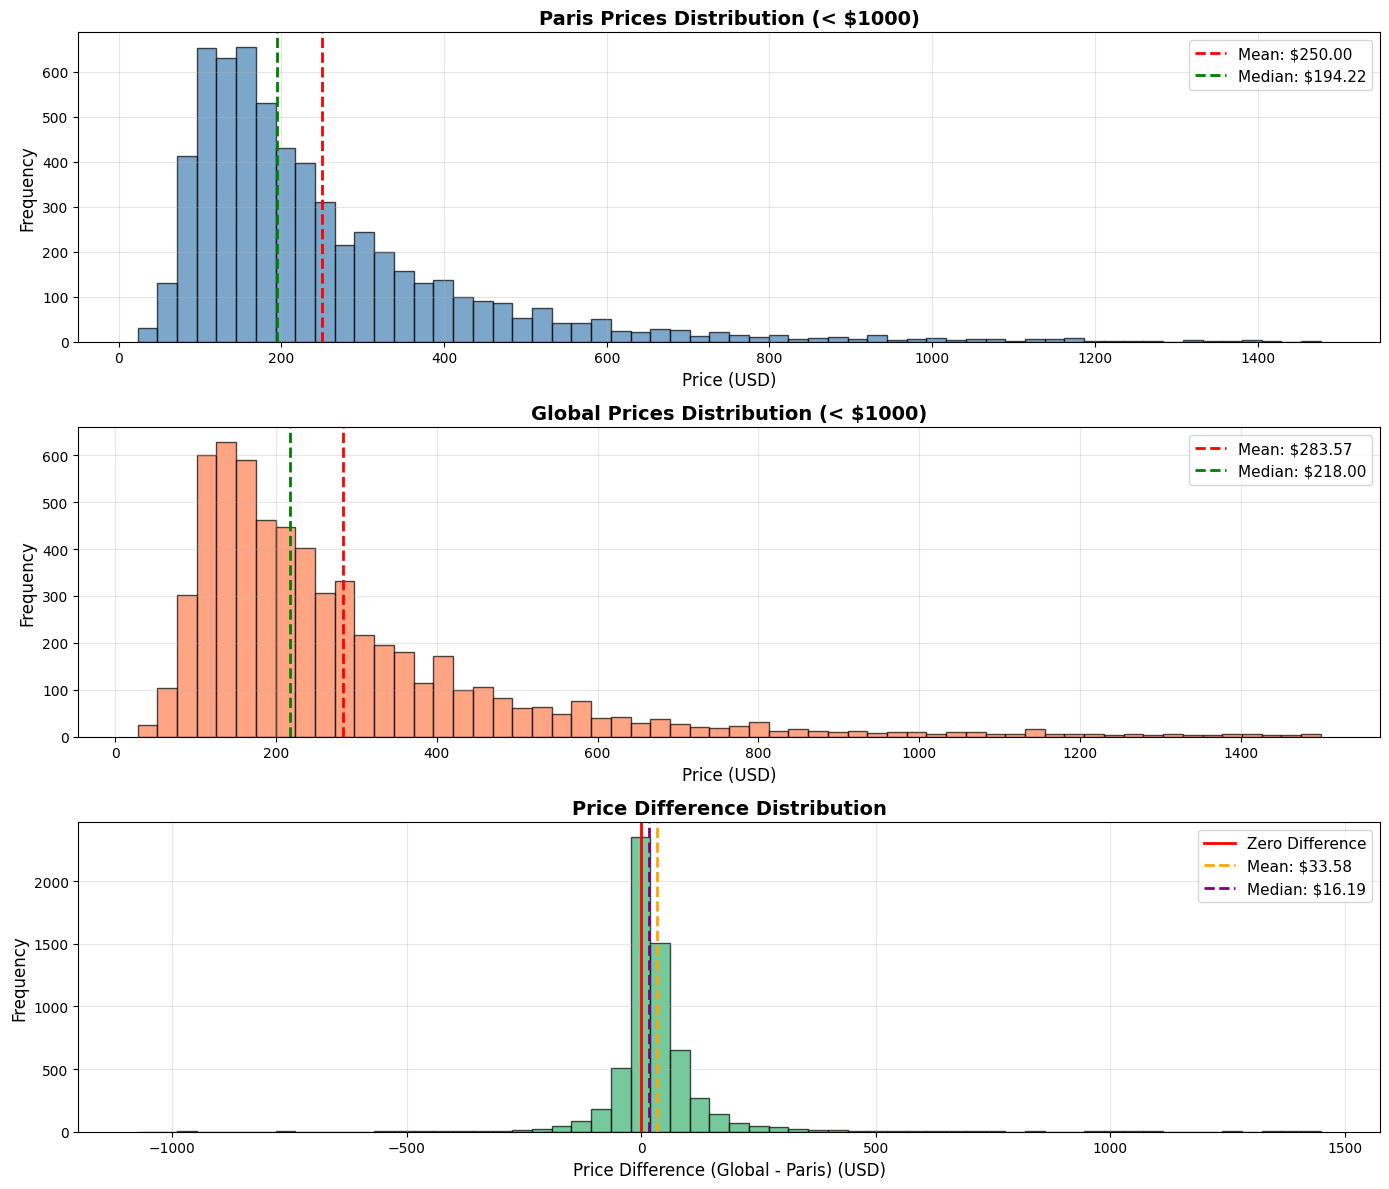

In [0]:
# Histograms for all three distributions
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Paris prices histogram
axes[0].hist(df_viz['price'], bins=60, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(df_viz['price'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${df_viz['price'].mean():.2f}")
axes[0].axvline(df_viz['price'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: ${df_viz['price'].median():.2f}")
axes[0].set_xlabel('Price (USD)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Paris Prices Distribution (< $1000)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Global prices histogram
axes[1].hist(df_viz['price_glob'], bins=60, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(df_viz['price_glob'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${df_viz['price_glob'].mean():.2f}")
axes[1].axvline(df_viz['price_glob'].median(), color='green', linestyle='--', linewidth=2, label=f"Median: ${df_viz['price_glob'].median():.2f}")
axes[1].set_xlabel('Price (USD)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Global Prices Distribution (< $1000)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Price difference histogram
axes[2].hist(df_viz['price_diff'], bins=60, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='red', linestyle='-', linewidth=2, label='Zero Difference')
axes[2].axvline(df_viz['price_diff'].mean(), color='orange', linestyle='--', linewidth=2, label=f"Mean: ${df_viz['price_diff'].mean():.2f}")
axes[2].axvline(df_viz['price_diff'].median(), color='purple', linestyle='--', linewidth=2, label=f"Median: ${df_viz['price_diff'].median():.2f}")
axes[2].set_xlabel('Price Difference (Global - Paris) (USD)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Price Difference Distribution', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

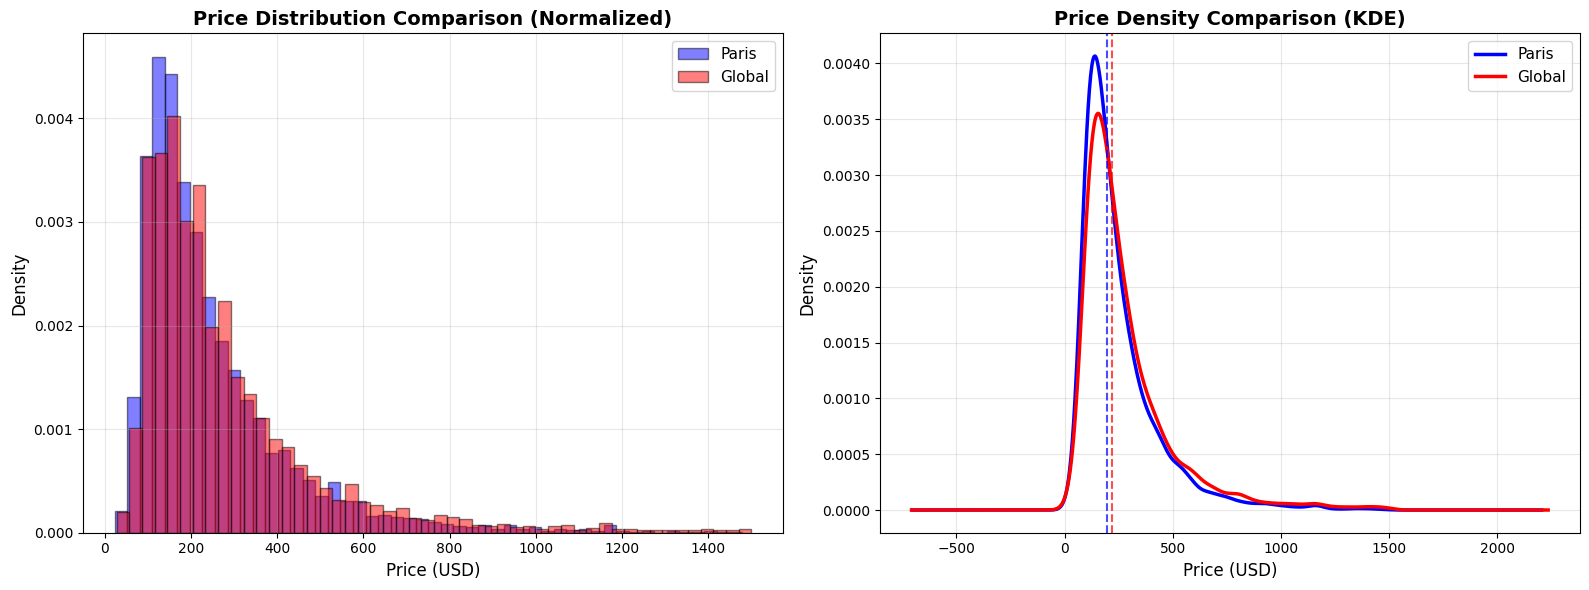


📊 Distribution Comparison:
Paris - Skewness: 2.351
Global - Skewness: 2.329
Difference - Skewness: 4.431


In [0]:
# Overlaid histograms and KDE plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overlaid histograms
axes[0].hist(df_viz['price'], bins=50, alpha=0.5, label='Paris', color='blue', edgecolor='black', density=True)
axes[0].hist(df_viz['price_glob'], bins=50, alpha=0.5, label='Global', color='red', edgecolor='black', density=True)
axes[0].set_xlabel('Price (USD)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Price Distribution Comparison (Normalized)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# KDE plots
df_viz['price'].plot(kind='kde', ax=axes[1], color='blue', linewidth=2.5, label='Paris')
df_viz['price_glob'].plot(kind='kde', ax=axes[1], color='red', linewidth=2.5, label='Global')
axes[1].axvline(df_viz['price'].median(), color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].axvline(df_viz['price_glob'].median(), color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Price (USD)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Price Density Comparison (KDE)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Distribution Comparison:")
print(f"Paris - Skewness: {df_viz['price'].skew():.3f}")
print(f"Global - Skewness: {df_viz['price_glob'].skew():.3f}")
print(f"Difference - Skewness: {df_viz['price_diff'].skew():.3f}")

#### log price distributions analysis

Following cells visualize and compare Paris and Global price distributions using overlaid histograms, KDEs, box plots, and log transformations to assess differences, spread, and the impact of log scaling.

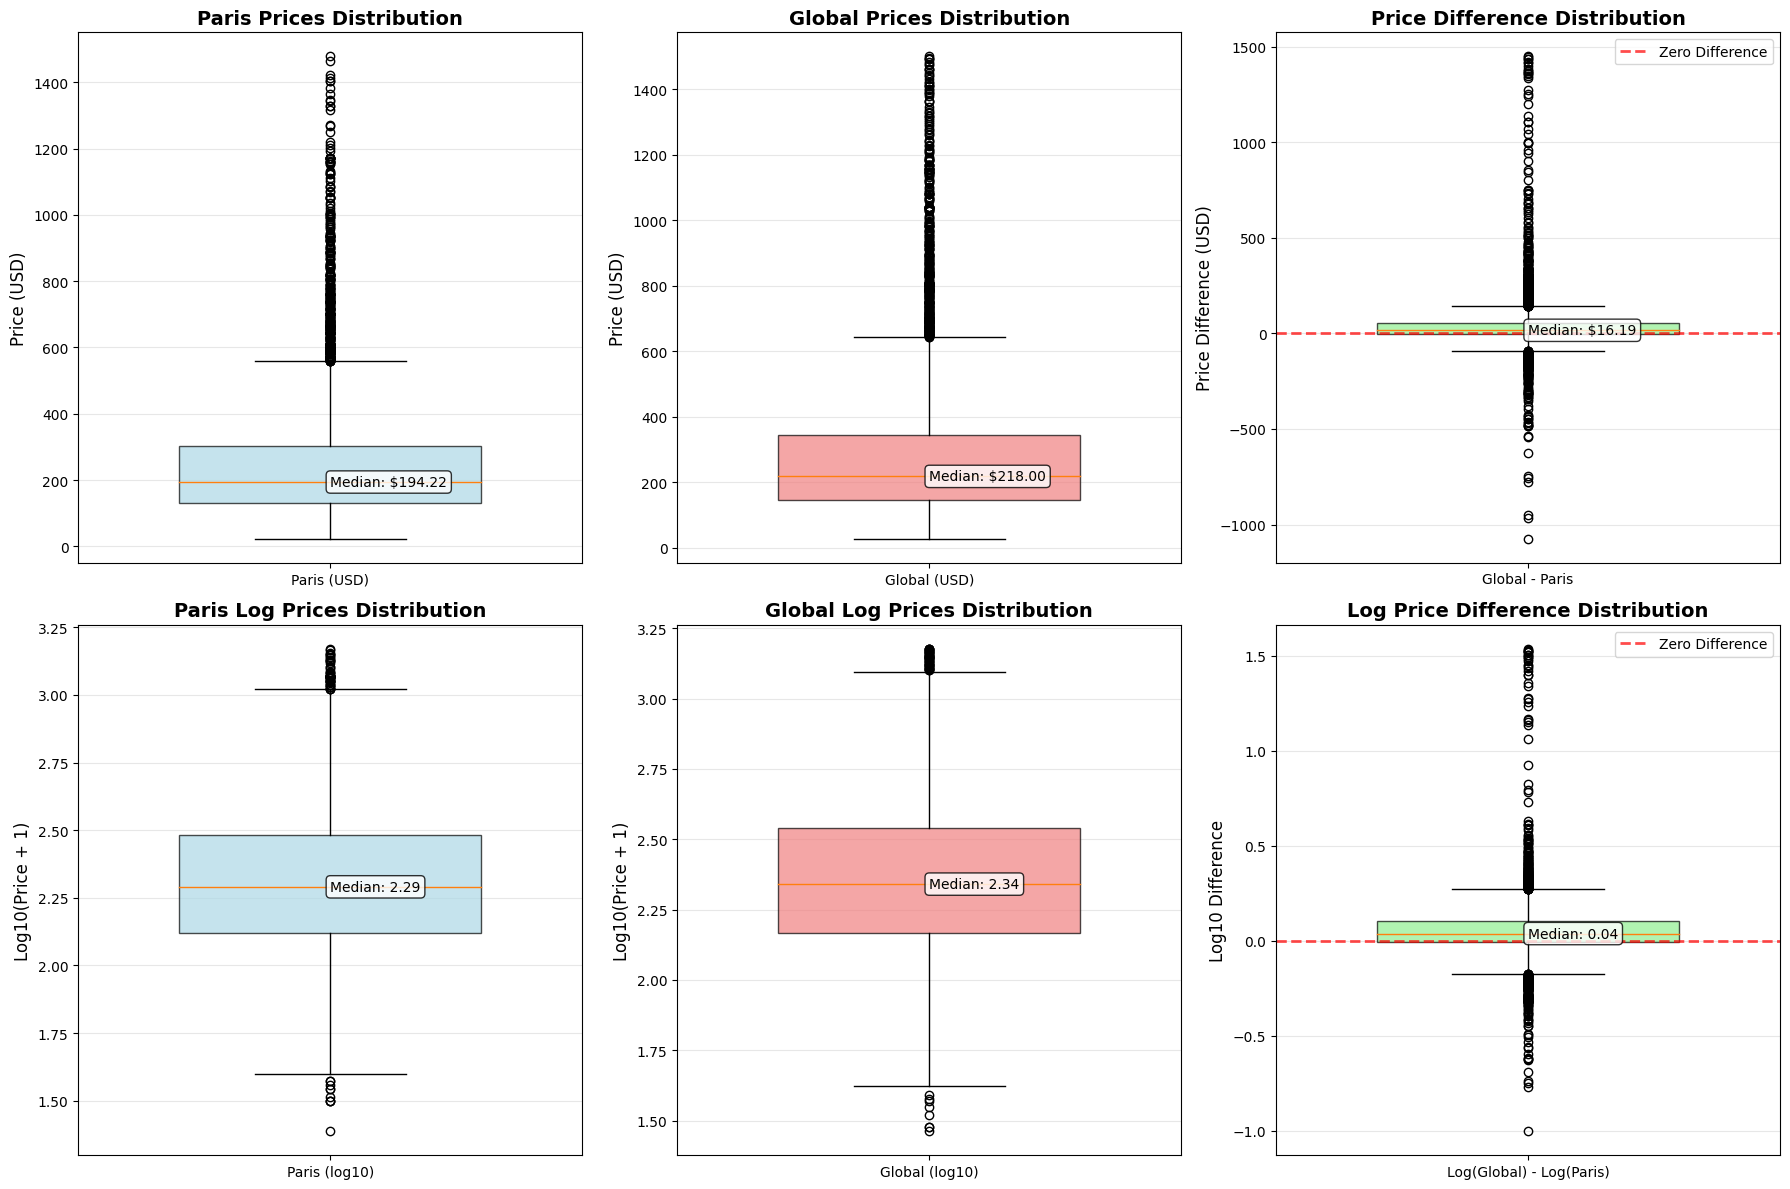


📊 Box Plot Insights (Linear):
Paris - IQR: $170.82
Global - IQR: $198.88
Difference - IQR: $58.89

📊 Box Plot Insights (Log):
Paris - IQR: 0.361
Global - IQR: 0.372
Difference - IQR: 0.112


In [0]:
# Box plots for all three distributions (linear and log)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Paris prices (linear)
box1 = axes[0, 0].boxplot([df_viz['price']], 
                          labels=['Paris (USD)'],
                          patch_artist=True,
                          widths=0.6)
box1['boxes'][0].set_facecolor('lightblue')
box1['boxes'][0].set_alpha(0.7)
axes[0, 0].set_ylabel('Price (USD)', fontsize=12)
axes[0, 0].set_title('Paris Prices Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].text(1, df_viz['price'].median(), 
                f"Median: ${df_viz['price'].median():.2f}",
                ha='left', va='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Global prices (linear)
box2 = axes[0, 1].boxplot([df_viz['price_glob']], 
                          labels=['Global (USD)'],
                          patch_artist=True,
                          widths=0.6)
box2['boxes'][0].set_facecolor('lightcoral')
box2['boxes'][0].set_alpha(0.7)
axes[0, 1].set_ylabel('Price (USD)', fontsize=12)
axes[0, 1].set_title('Global Prices Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].text(1, df_viz['price_glob'].median(), 
                f"Median: ${df_viz['price_glob'].median():.2f}",
                ha='left', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Price difference (linear)
box3 = axes[0, 2].boxplot([df_viz['price_diff']], 
                          labels=['Global - Paris'],
                          patch_artist=True,
                          widths=0.6)
box3['boxes'][0].set_facecolor('lightgreen')
box3['boxes'][0].set_alpha(0.7)
axes[0, 2].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero Difference')
axes[0, 2].set_ylabel('Price Difference (USD)', fontsize=12)
axes[0, 2].set_title('Price Difference Distribution', fontsize=14, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)
axes[0, 2].legend(fontsize=10)
axes[0, 2].text(1, df_viz['price_diff'].median(), 
                f"Median: ${df_viz['price_diff'].median():.2f}",
                ha='left', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Paris log prices
box4 = axes[1, 0].boxplot([df_viz['log_price']], 
                          labels=['Paris (log10)'],
                          patch_artist=True,
                          widths=0.6)
box4['boxes'][0].set_facecolor('lightblue')
box4['boxes'][0].set_alpha(0.7)
axes[1, 0].set_ylabel('Log10(Price + 1)', fontsize=12)
axes[1, 0].set_title('Paris Log Prices Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].text(1, df_viz['log_price'].median(), 
                f"Median: {df_viz['log_price'].median():.2f}",
                ha='left', va='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Global log prices
box5 = axes[1, 1].boxplot([df_viz['log_price_glob']], 
                          labels=['Global (log10)'],
                          patch_artist=True,
                          widths=0.6)
box5['boxes'][0].set_facecolor('lightcoral')
box5['boxes'][0].set_alpha(0.7)
axes[1, 1].set_ylabel('Log10(Price + 1)', fontsize=12)
axes[1, 1].set_title('Global Log Prices Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].text(1, df_viz['log_price_glob'].median(), 
                f"Median: {df_viz['log_price_glob'].median():.2f}",
                ha='left', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Log price difference
box6 = axes[1, 2].boxplot([df_viz['log_price_diff']], 
                          labels=['Log(Global) - Log(Paris)'],
                          patch_artist=True,
                          widths=0.6)
box6['boxes'][0].set_facecolor('lightgreen')
box6['boxes'][0].set_alpha(0.7)
axes[1, 2].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero Difference')
axes[1, 2].set_ylabel('Log10 Difference', fontsize=12)
axes[1, 2].set_title('Log Price Difference Distribution', fontsize=14, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)
axes[1, 2].legend(fontsize=10)
axes[1, 2].text(1, df_viz['log_price_diff'].median(), 
                f"Median: {df_viz['log_price_diff'].median():.2f}",
                ha='left', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n📊 Box Plot Insights (Linear):")
print(f"Paris - IQR: ${df_viz['price'].quantile(0.75) - df_viz['price'].quantile(0.25):.2f}")
print(f"Global - IQR: ${df_viz['price_glob'].quantile(0.75) - df_viz['price_glob'].quantile(0.25):.2f}")
print(f"Difference - IQR: ${df_viz['price_diff'].quantile(0.75) - df_viz['price_diff'].quantile(0.25):.2f}")

print("\n📊 Box Plot Insights (Log):")
print(f"Paris - IQR: {df_viz['log_price'].quantile(0.75) - df_viz['log_price'].quantile(0.25):.3f}")
print(f"Global - IQR: {df_viz['log_price_glob'].quantile(0.75) - df_viz['log_price_glob'].quantile(0.25):.3f}")
print(f"Difference - IQR: {df_viz['log_price_diff'].quantile(0.75) - df_viz['log_price_diff'].quantile(0.25):.3f}")

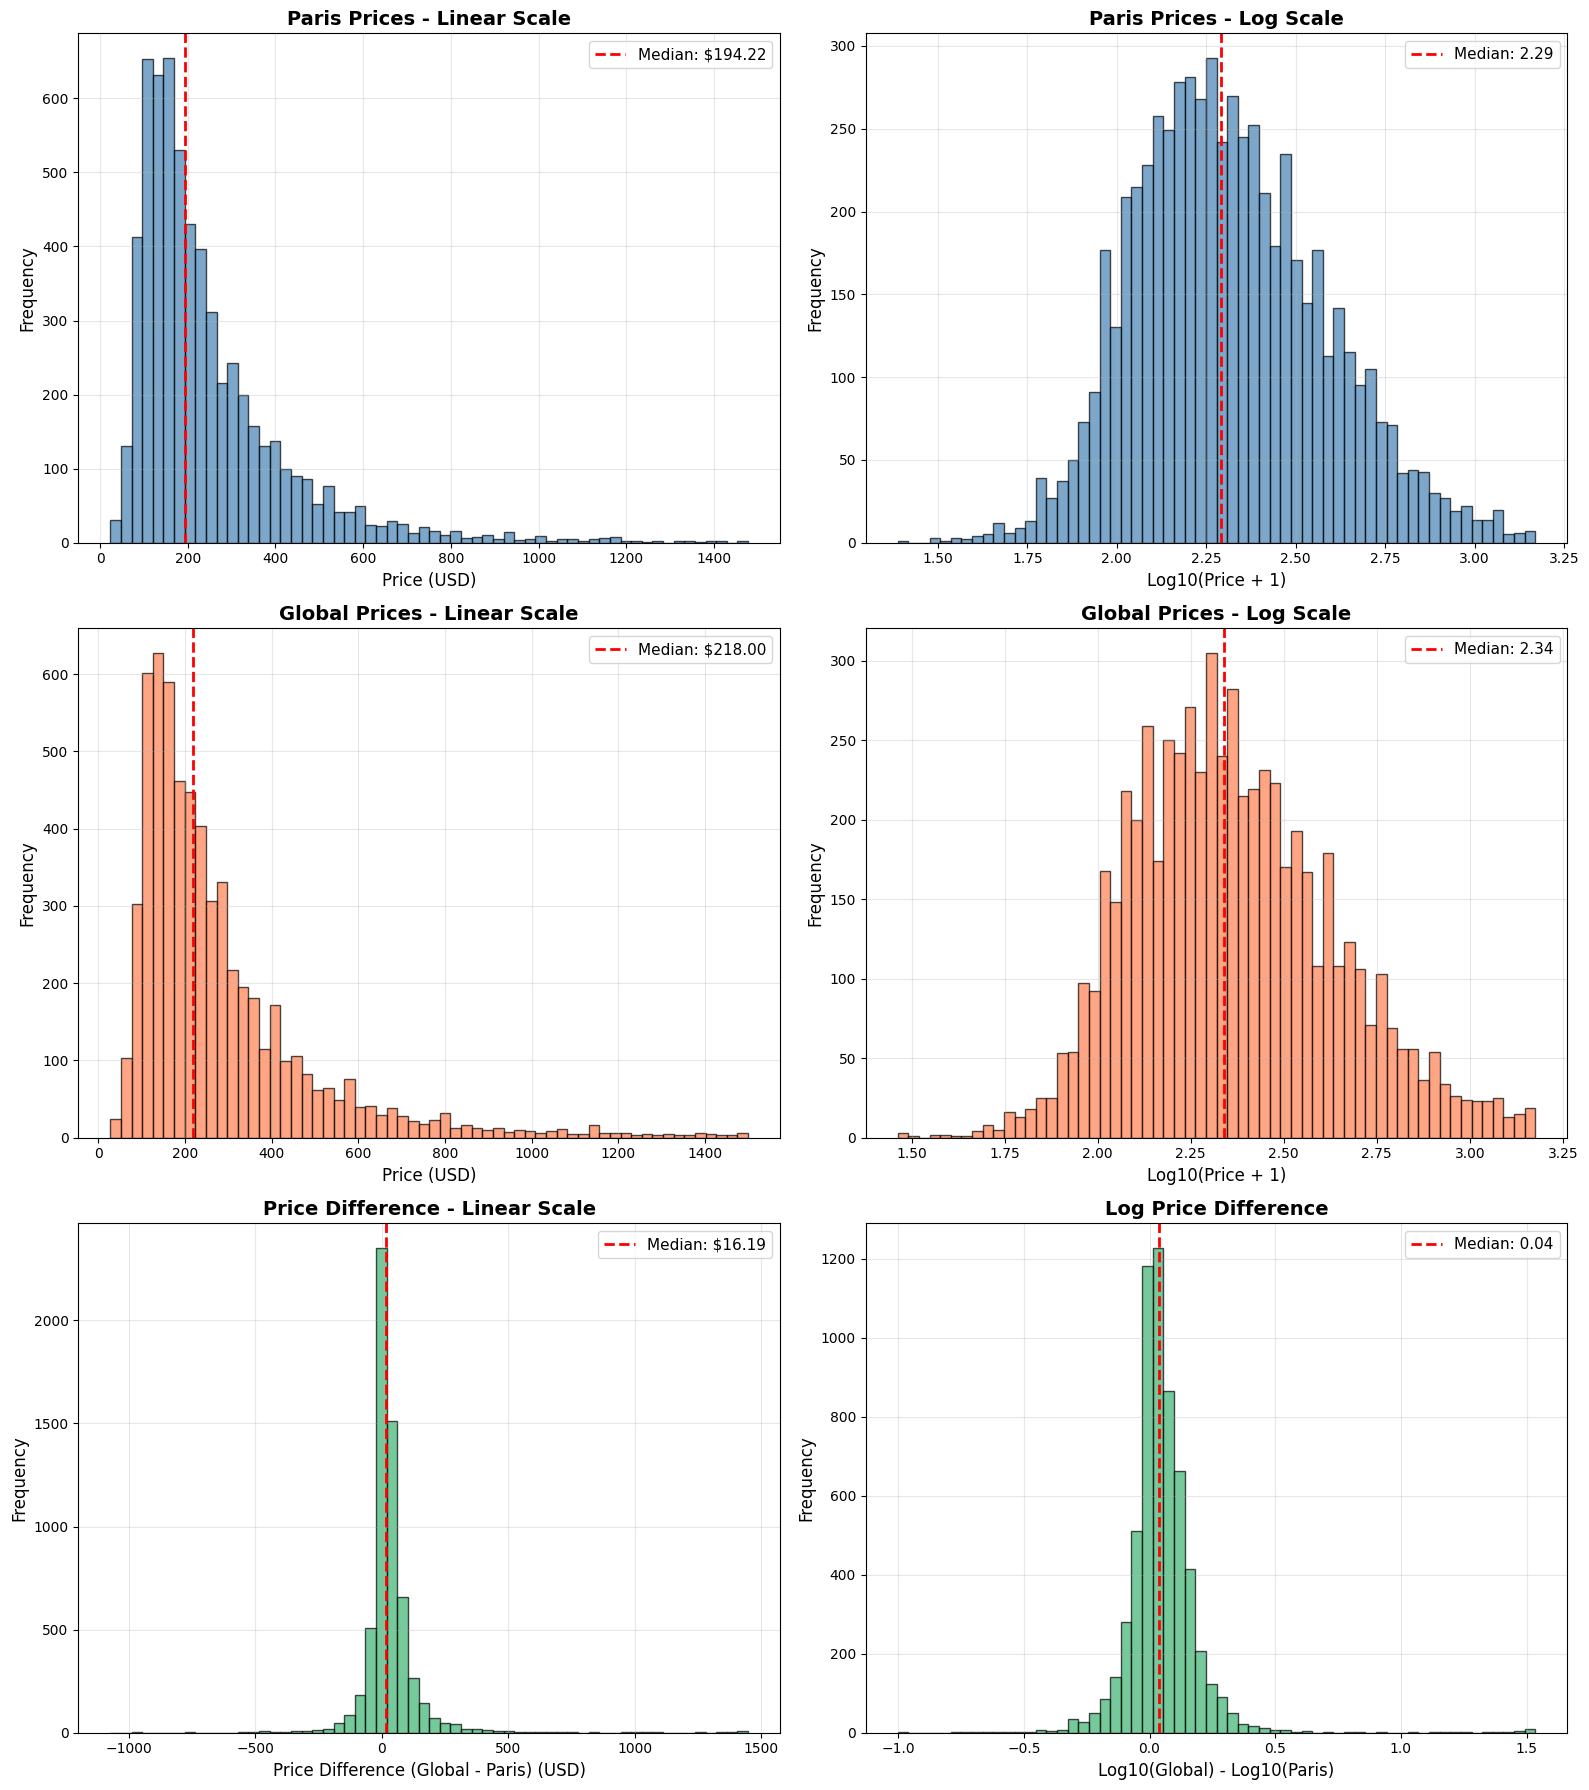


📊 Log-scale reveals the distribution shape across the full price range


In [0]:
# Histograms on log scale
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Paris prices - Linear scale
axes[0, 0].hist(df_viz['price'], bins=60, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_viz['price'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: ${df_viz['price'].median():.2f}")
axes[0, 0].set_xlabel('Price (USD)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Paris Prices - Linear Scale', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Paris prices - Log scale
axes[0, 1].hist(df_viz['log_price'], bins=60, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_viz['log_price'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {df_viz['log_price'].median():.2f}")
axes[0, 1].set_xlabel('Log10(Price + 1)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Paris Prices - Log Scale', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Global prices - Linear scale
axes[1, 0].hist(df_viz['price_glob'], bins=60, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(df_viz['price_glob'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: ${df_viz['price_glob'].median():.2f}")
axes[1, 0].set_xlabel('Price (USD)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Global Prices - Linear Scale', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

# Global prices - Log scale
axes[1, 1].hist(df_viz['log_price_glob'], bins=60, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(df_viz['log_price_glob'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {df_viz['log_price_glob'].median():.2f}")
axes[1, 1].set_xlabel('Log10(Price + 1)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Global Prices - Log Scale', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

# Price difference - Linear scale
axes[2, 0].hist(df_viz['price_diff'], bins=60, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[2, 0].axvline(df_viz['price_diff'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: ${df_viz['price_diff'].median():.2f}")
axes[2, 0].set_xlabel('Price Difference (Global - Paris) (USD)', fontsize=12)
axes[2, 0].set_ylabel('Frequency', fontsize=12)
axes[2, 0].set_title('Price Difference - Linear Scale', fontsize=14, fontweight='bold')
axes[2, 0].legend(fontsize=11)
axes[2, 0].grid(alpha=0.3)

# Price difference - Log scale
axes[2, 1].hist(df_viz['log_price_diff'], bins=60, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[2, 1].axvline(df_viz['log_price_diff'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {df_viz['log_price_diff'].median():.2f}")
axes[2, 1].set_xlabel('Log10(Global) - Log10(Paris)', fontsize=12)
axes[2, 1].set_ylabel('Frequency', fontsize=12)
axes[2, 1].set_title('Log Price Difference', fontsize=14, fontweight='bold')
axes[2, 1].legend(fontsize=11)
axes[2, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Log-scale reveals the distribution shape across the full price range")

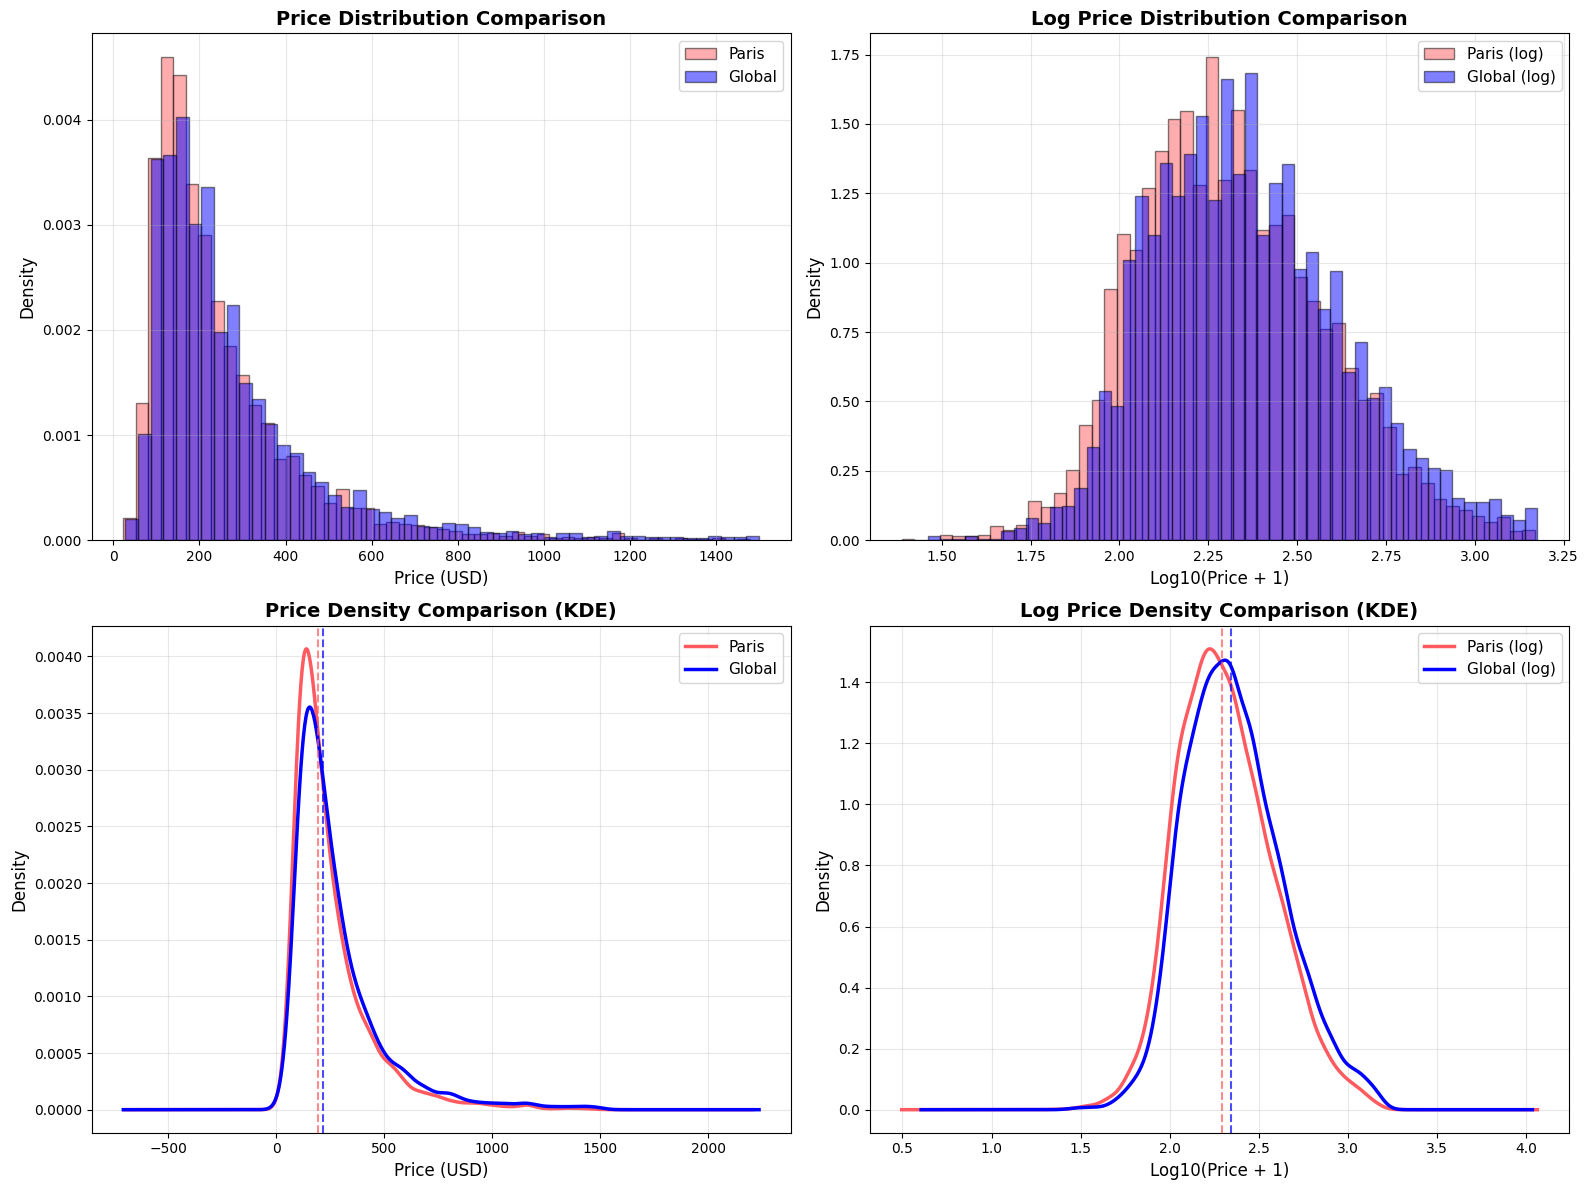

In [0]:
# Overlaid distributions on log scale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Row 1: Linear-scale histogram and log-scale histogram (side by side)
axes[0, 0].hist(df_viz['price'], bins=50, alpha=0.5, label='Paris', color='#FF5A5F', edgecolor='black', density=True)
axes[0, 0].hist(df_viz['price_glob'], bins=50, alpha=0.5, label='Global', color='blue', edgecolor='black', density=True)
axes[0, 0].set_xlabel('Price (USD)', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Price Distribution Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df_viz['log_price'], bins=50, alpha=0.5, label='Paris (log)', color='#FF5A5F', edgecolor='black', density=True)
axes[0, 1].hist(df_viz['log_price_glob'], bins=50, alpha=0.5, label='Global (log)', color='blue', edgecolor='black', density=True)
axes[0, 1].set_xlabel('Log10(Price + 1)', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('Log Price Distribution Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Row 2: Linear-scale KDE and log-scale KDE (side by side)
df_viz['price'].plot(kind='kde', ax=axes[1, 0], color='#FF5A5F', linewidth=2.5, label='Paris')
df_viz['price_glob'].plot(kind='kde', ax=axes[1, 0], color='blue', linewidth=2.5, label='Global')
axes[1, 0].axvline(df_viz['price'].median(), color='#FF5A5F', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 0].axvline(df_viz['price_glob'].median(), color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 0].set_xlabel('Price (USD)', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Price Density Comparison (KDE)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

df_viz['log_price'].plot(kind='kde', ax=axes[1, 1], color='#FF5A5F', linewidth=2.5, label='Paris (log)')
df_viz['log_price_glob'].plot(kind='kde', ax=axes[1, 1], color='blue', linewidth=2.5, label='Global (log)')
axes[1, 1].axvline(df_viz['log_price'].median(), color='#FF5A5F', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 1].axvline(df_viz['log_price_glob'].median(), color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 1].set_xlabel('Log10(Price + 1)', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].set_title('Log Price Density Comparison (KDE)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

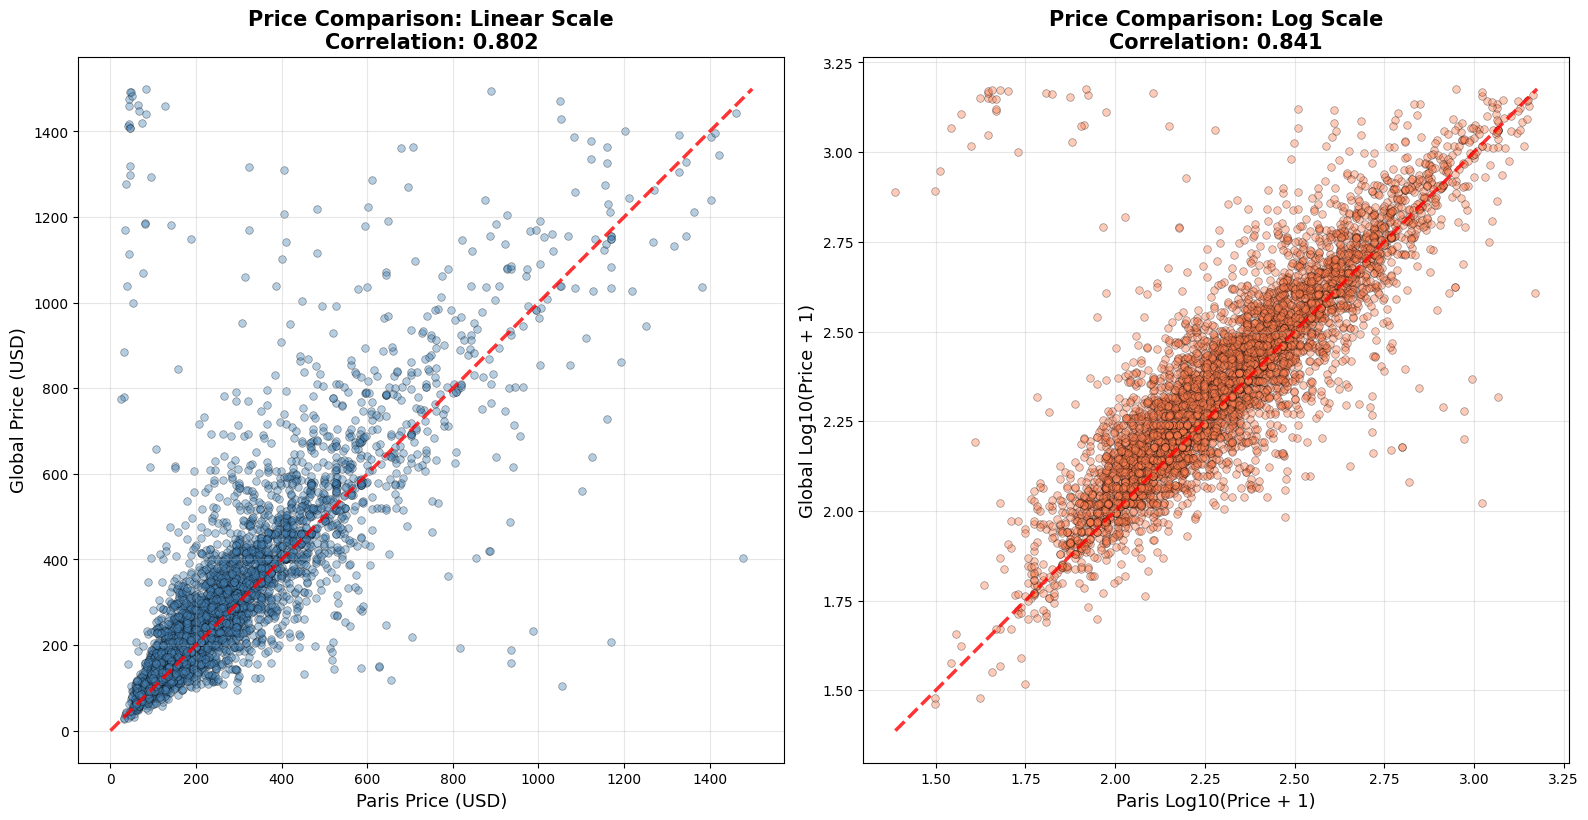

SCATTER PLOT ANALYSIS

📊 Linear Scale:
  Correlation: 0.802
  Points above diagonal (Global > Paris): 3,978 (65.3%)
  Points below diagonal (Global < Paris): 2,118 (34.7%)
  Points on diagonal (Equal prices): 0 (0.0%)

📊 Log Scale:
  Correlation: 0.841
  Points above diagonal (Global > Paris): 3,978 (65.3%)
  Points below diagonal (Global < Paris): 2,118 (34.7%)
  Points on diagonal (Equal log prices): 0 (0.0%)

💡 Comparison:
✓ Log scale shows STRONGER correlation (difference: 0.039)
  → Prices have a better linear relationship on log scale
  → This suggests multiplicative/percentage relationships between prices


In [0]:
# Scatter plots: Linear and Log scale side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Calculate correlations first
corr_linear = df_viz[['price', 'price_glob']].corr().iloc[0, 1]
corr_log = df_viz[['log_price', 'log_price_glob']].corr().iloc[0, 1]

# LEFT: Linear scale scatter plot
axes[0].scatter(df_viz['price'], df_viz['price_glob'], 
                alpha=0.4, s=30, color='steelblue', edgecolors='black', linewidth=0.5)
max_price = max(df_viz['price'].max(), df_viz['price_glob'].max())
axes[0].plot([0, max_price], [0, max_price], 'r--', linewidth=2.5, label='Perfect Agreement (y=x)', alpha=0.8)
axes[0].set_xlabel('Paris Price (USD)', fontsize=13)
axes[0].set_ylabel('Global Price (USD)', fontsize=13)
axes[0].set_title(f'Price Comparison: Linear Scale\nCorrelation: {corr_linear:.3f}', fontsize=15, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_aspect('equal')

# RIGHT: Log scale scatter plot
axes[1].scatter(df_viz['log_price'], df_viz['log_price_glob'], 
                alpha=0.4, s=30, color='coral', edgecolors='black', linewidth=0.5)
max_log = max(df_viz['log_price'].max(), df_viz['log_price_glob'].max())
min_log = min(df_viz['log_price'].min(), df_viz['log_price_glob'].min())
axes[1].plot([min_log, max_log], [min_log, max_log], 'r--', linewidth=2.5, label='Perfect Agreement (y=x)', alpha=0.8)
axes[1].set_xlabel('Paris Log10(Price + 1)', fontsize=13)
axes[1].set_ylabel('Global Log10(Price + 1)', fontsize=13)
axes[1].set_title(f'Price Comparison: Log Scale\nCorrelation: {corr_log:.3f}', fontsize=15, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("=" * 80)
print("SCATTER PLOT ANALYSIS")
print("=" * 80)

print(f"\n📊 Linear Scale:")
print(f"  Correlation: {corr_linear:.3f}")
print(f"  Points above diagonal (Global > Paris): {(df_viz['price_glob'] > df_viz['price']).sum():,} ({(df_viz['price_glob'] > df_viz['price']).sum()/len(df_viz)*100:.1f}%)")
print(f"  Points below diagonal (Global < Paris): {(df_viz['price_glob'] < df_viz['price']).sum():,} ({(df_viz['price_glob'] < df_viz['price']).sum()/len(df_viz)*100:.1f}%)")
print(f"  Points on diagonal (Equal prices): {(df_viz['price_glob'] == df_viz['price']).sum():,} ({(df_viz['price_glob'] == df_viz['price']).sum()/len(df_viz)*100:.1f}%)")

print(f"\n📊 Log Scale:")
print(f"  Correlation: {corr_log:.3f}")
print(f"  Points above diagonal (Global > Paris): {(df_viz['log_price_glob'] > df_viz['log_price']).sum():,} ({(df_viz['log_price_glob'] > df_viz['log_price']).sum()/len(df_viz)*100:.1f}%)")
print(f"  Points below diagonal (Global < Paris): {(df_viz['log_price_glob'] < df_viz['log_price']).sum():,} ({(df_viz['log_price_glob'] < df_viz['log_price']).sum()/len(df_viz)*100:.1f}%)")
print(f"  Points on diagonal (Equal log prices): {(df_viz['log_price_glob'] == df_viz['log_price']).sum():,} ({(df_viz['log_price_glob'] == df_viz['log_price']).sum()/len(df_viz)*100:.1f}%)")

print(f"\n💡 Comparison:")
if corr_log > corr_linear:
    print(f"✓ Log scale shows STRONGER correlation (difference: {corr_log - corr_linear:.3f})")
    print(f"  → Prices have a better linear relationship on log scale")
    print(f"  → This suggests multiplicative/percentage relationships between prices")
else:
    print(f"✓ Linear scale shows stronger correlation (difference: {corr_linear - corr_log:.3f})")
    print(f"  → Prices have a better linear relationship on original scale")

In [0]:
# Comprehensive summary statistics - Linear and Log scale
print("=" * 90)
print("COMPREHENSIVE PRICE STATISTICS SUMMARY - LINEAR AND LOG SCALE")
print("=" * 90)

summary_data = {
    'Metric': ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Q1', 'Q3', 'Max', 'Skewness', 'Kurtosis'],
    'Paris (USD)': [
        len(df_viz),
        f"${df_viz['price'].mean():.2f}",
        f"${df_viz['price'].median():.2f}",
        f"${df_viz['price'].std():.2f}",
        f"${df_viz['price'].min():.2f}",
        f"${df_viz['price'].quantile(0.25):.2f}",
        f"${df_viz['price'].quantile(0.75):.2f}",
        f"${df_viz['price'].max():.2f}",
        f"{df_viz['price'].skew():.3f}",
        f"{df_viz['price'].kurtosis():.3f}"
    ],
    'Global (USD)': [
        len(df_viz),
        f"${df_viz['price_glob'].mean():.2f}",
        f"${df_viz['price_glob'].median():.2f}",
        f"${df_viz['price_glob'].std():.2f}",
        f"${df_viz['price_glob'].min():.2f}",
        f"${df_viz['price_glob'].quantile(0.25):.2f}",
        f"${df_viz['price_glob'].quantile(0.75):.2f}",
        f"${df_viz['price_glob'].max():.2f}",
        f"{df_viz['price_glob'].skew():.3f}",
        f"{df_viz['price_glob'].kurtosis():.3f}"
    ],
    'Difference': [
        len(df_viz),
        f"${df_viz['price_diff'].mean():.2f}",
        f"${df_viz['price_diff'].median():.2f}",
        f"${df_viz['price_diff'].std():.2f}",
        f"${df_viz['price_diff'].min():.2f}",
        f"${df_viz['price_diff'].quantile(0.25):.2f}",
        f"${df_viz['price_diff'].quantile(0.75):.2f}",
        f"${df_viz['price_diff'].max():.2f}",
        f"{df_viz['price_diff'].skew():.3f}",
        f"{df_viz['price_diff'].kurtosis():.3f}"
    ],
    'Paris (Log)': [
        len(df_viz),
        f"{df_viz['log_price'].mean():.4f}",
        f"{df_viz['log_price'].median():.4f}",
        f"{df_viz['log_price'].std():.4f}",
        f"{df_viz['log_price'].min():.4f}",
        f"{df_viz['log_price'].quantile(0.25):.4f}",
        f"{df_viz['log_price'].quantile(0.75):.4f}",
        f"{df_viz['log_price'].max():.4f}",
        f"{df_viz['log_price'].skew():.3f}",
        f"{df_viz['log_price'].kurtosis():.3f}"
    ],
    'Global (Log)': [
        len(df_viz),
        f"{df_viz['log_price_glob'].mean():.4f}",
        f"{df_viz['log_price_glob'].median():.4f}",
        f"{df_viz['log_price_glob'].std():.4f}",
        f"{df_viz['log_price_glob'].min():.4f}",
        f"{df_viz['log_price_glob'].quantile(0.25):.4f}",
        f"{df_viz['log_price_glob'].quantile(0.75):.4f}",
        f"{df_viz['log_price_glob'].max():.4f}",
        f"{df_viz['log_price_glob'].skew():.3f}",
        f"{df_viz['log_price_glob'].kurtosis():.3f}"
    ],
    'Log Diff': [
        len(df_viz),
        f"{df_viz['log_price_diff'].mean():.4f}",
        f"{df_viz['log_price_diff'].median():.4f}",
        f"{df_viz['log_price_diff'].std():.4f}",
        f"{df_viz['log_price_diff'].min():.4f}",
        f"{df_viz['log_price_diff'].quantile(0.25):.4f}",
        f"{df_viz['log_price_diff'].quantile(0.75):.4f}",
        f"{df_viz['log_price_diff'].max():.4f}",
        f"{df_viz['log_price_diff'].skew():.3f}",
        f"{df_viz['log_price_diff'].kurtosis():.3f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "=" * 90)
print("CORRELATION ANALYSIS")
print("=" * 90)
print(f"\nLinear Scale Correlation: {corr_linear:.4f}")
print(f"Log Scale Correlation: {corr_log:.4f}")
print(f"Correlation Difference: {abs(corr_log - corr_linear):.4f}")

if corr_log > corr_linear:
    print(f"\n✓ Log scale shows STRONGER correlation")
    print(f"  → Prices have better linear relationship on log scale")
    print(f"  → Suggests multiplicative/percentage relationships")
else:
    print(f"\n✓ Linear scale shows stronger correlation")
    print(f"  → Prices have better linear relationship on original scale")

print("\n" + "=" * 90)
print("KEY INSIGHTS")
print("=" * 90)

mean_diff = df_viz['price_diff'].mean()
median_diff = df_viz['price_diff'].median()
mean_log_diff = df_viz['log_price_diff'].mean()

if mean_diff > 0:
    print(f"\n✓ Linear: On average, Global prices are ${abs(mean_diff):.2f} HIGHER than Paris prices")
else:
    print(f"\n✓ Linear: On average, Global prices are ${abs(mean_diff):.2f} LOWER than Paris prices")

if median_diff > 0:
    print(f"✓ Linear: Median difference is ${abs(median_diff):.2f} (Global HIGHER)")
else:
    print(f"✓ Linear: Median difference is ${abs(median_diff):.2f} (Global LOWER)")

print(f"\n✓ Log: Mean log difference is {mean_log_diff:.4f}")
if abs(mean_log_diff) < 0.05:
    print(f"  → Prices are very similar (< 12% difference)")
elif abs(mean_log_diff) < 0.1:
    print(f"  → Prices are moderately similar (< 26% difference)")
else:
    pct_diff = (10**abs(mean_log_diff) - 1) * 100
    print(f"  → Prices show notable differences (~{pct_diff:.1f}% difference)")

print(f"\n✓ Distribution: {(df_viz['price_diff'] > 0).sum() / len(df_viz) * 100:.1f}% of listings have higher Global prices")
print(f"✓ Distribution: {(df_viz['price_diff'] < 0).sum() / len(df_viz) * 100:.1f}% of listings have higher Paris prices")
print(f"✓ Distribution: {(df_viz['price_diff'] == 0).sum() / len(df_viz) * 100:.1f}% of listings have identical prices")

print(f"\n✓ Skewness: Paris={df_viz['price'].skew():.3f}, Global={df_viz['price_glob'].skew():.3f}")
if df_viz['price'].skew() > 1 or df_viz['price_glob'].skew() > 1:
    print(f"  → Highly right-skewed distributions (log transformation recommended)")
elif df_viz['price'].skew() > 0.5 or df_viz['price_glob'].skew() > 0.5:
    print(f"  → Moderately right-skewed distributions")
else:
    print(f"  → Relatively symmetric distributions")

COMPREHENSIVE PRICE STATISTICS SUMMARY - LINEAR AND LOG SCALE

  Metric Paris (USD) Global (USD) Difference Paris (Log) Global (Log) Log Diff
   Count        6096         6096       6096        6096         6096     6096
    Mean     $250.00      $283.57     $33.58      2.3135       2.3630   0.0495
  Median     $194.22      $218.00     $16.19      2.2905       2.3404   0.0375
 Std Dev     $183.23      $215.50    $129.17      0.2649       0.2711   0.1514
     Min      $23.40       $28.00  $-1073.71      1.3874       1.4624  -1.0023
      Q1     $131.04      $145.59     $-5.36      2.1207       2.1661  -0.0081
      Q3     $301.86      $344.47     $53.53      2.4812       2.5384   0.1035
     Max    $1477.71     $1499.43   $1448.65      3.1699       3.1762   1.5352
Skewness       2.351        2.329      4.431       0.350        0.397    3.242
Kurtosis       7.639        6.891     46.134       0.003        0.003   31.000

CORRELATION ANALYSIS

Linear Scale Correlation: 0.8019
Log Scale Co

#### Residual Analysis

The following cells perform error and residual analysis for the calibrated price model. They visualize residuals, check for normality and bias, and summarize the calibration's effectiveness in reducing error and bias between global and Paris Airbnb prices. The analysis confirms improved model accuracy and unbiased predictions after robust log-based calibration.

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Prepare the Data (Assuming you have the overlapping dataset loaded)
# We treat the raw 'Global Price' as if it were the model's prediction
X = df_viz['price_glob'].values  # Input (The "Biased" Global Data)
y = df_viz['price'].values       # Target (The "True" Local Data)

# Split into Mock Train (for Calibration) and Mock Test (for Validation)
# Note: In the real project, this split will be different, but this is just a POC.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- BASELINE (Before Calibration) ---
rmse_baseline = np.sqrt(mean_squared_error(y_test, X_test))
mae_baseline = mean_absolute_error(y_test, X_test)
bias_baseline = np.mean(X_test - y_test)
print(f"--- Baseline (Raw Global Data) ---")
print(f"RMSE: ${rmse_baseline:.2f}")
print(f"MAE:  ${mae_baseline:.2f}")
print(f"Bias: ${bias_baseline:.2f}") # Checking systematic error

# --- CALIBRATION (The Proof of Concept) ---

# A. Transform to Log Space
X_train_log = np.log1p(X_train).reshape(-1, 1)
y_train_log = np.log1p(y_train)
X_test_log = np.log1p(X_test).reshape(-1, 1)

# B. Train Robust Calibrator (Huber)
calibrator = HuberRegressor()
calibrator.fit(X_train_log, y_train_log)

# C. Predict & Inverse Transform
y_pred_log = calibrator.predict(X_test_log)
y_pred_calibrated = np.expm1(y_pred_log)

# --- RESULTS (After Calibration) ---
rmse_calib = np.sqrt(mean_squared_error(y_test, y_pred_calibrated))
mae_calib = mean_absolute_error(y_test, y_pred_calibrated)
bias_calib = np.mean(y_pred_calibrated - y_test)

print(f"\n--- After Robust Log-Calibration ---")
print(f"RMSE: ${rmse_calib:.2f} (Improvement: {100*(rmse_baseline-rmse_calib)/rmse_baseline:.1f}%)")
print(f"MAE:  ${mae_calib:.2f} (Improvement: {100*(mae_baseline-mae_calib)/mae_baseline:.1f}%)")
print(f"Bias: ${bias_calib:.2f} (Improvement: {100*np.abs((bias_baseline-bias_calib)/bias_baseline):.1f}%)") # Should be close to 0

--- Baseline (Raw Global Data) ---
RMSE: $130.33
MAE:  $64.14
Bias: $35.34


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run monumental-sloth-198 at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/725232465060523/runs/2852df89e28a4ab9992583ccdc5c0a3f
🧪 View experiment at: https://adb-983293358114278.18.azuredatabricks.net/ml/experiments/725232465060523

--- After Robust Log-Calibration ---
RMSE: $107.03 (Improvement: 17.9%)
MAE:  $53.70 (Improvement: 16.3%)
Bias: $-0.57 (Improvement: 101.6%)


Generating Error Analysis Visualizations...


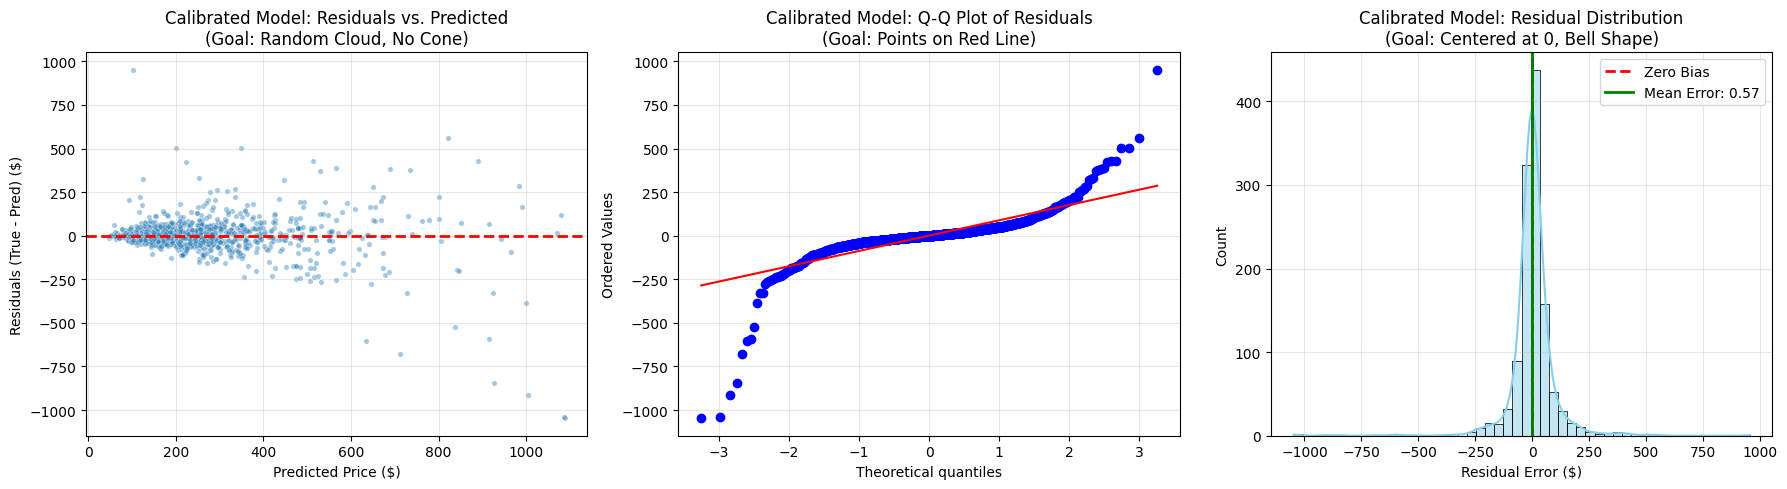

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

def plot_error_analysis(y_true, y_pred, title_prefix=""): #TODO: move function to utils.py
    """
    Generates a 3-panel error analysis dashboard:
    1. Residuals vs. Predicted (Check for Homoscedasticity)
    2. Q-Q Plot (Check for Normality)
    3. Error Distribution (Check for Centering/Bias)
    """
    # Calculate Residuals
    residuals = y_true - y_pred
    log_residuals = np.log1p(y_true) - np.log1p(y_pred) # Log residuals are often more informative for pricing

    plt.figure(figsize=(18, 5))

    # --- Plot 1: Residuals vs Predicted (Scatter) ---
    # Goal: Ensure there is no "pattern" (like a fan or banana shape). We want a random cloud around zero.
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred, residuals, alpha=0.4, s=15, edgecolors='w', linewidth=0.5)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Price ($)')
    plt.ylabel('Residuals (True - Pred) ($)')
    plt.title(f'{title_prefix} Residuals vs. Predicted\n(Goal: Random Cloud, No Cone)')
    plt.grid(True, alpha=0.3)
    
    # Optional: Add running average to see bias across price ranges
    # sns.regplot(x=y_pred, y=residuals, scatter=False, lowess=True, line_kws={'color': 'green', 'ls': '-.'})


    # --- Plot 2: Q-Q Plot (Normality Check) ---
    # Goal: Ensure the errors are normally distributed. The points should lie on the red line.
    plt.subplot(1, 3, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'{title_prefix} Q-Q Plot of Residuals\n(Goal: Points on Red Line)')
    plt.grid(True, alpha=0.3)


    # --- Plot 3: Error Distribution Histogram ---
    # Goal: Ensure the mean is 0 (Unbiased) and the distribution is symmetric.
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Bias')
    plt.axvline(np.mean(residuals), color='green', linestyle='-', linewidth=2, label=f'Mean Error: {np.mean(residuals):.2f}')
    plt.xlabel('Residual Error ($)')
    plt.title(f'{title_prefix} Residual Distribution\n(Goal: Centered at 0, Bell Shape)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Generating Error Analysis Visualizations...")
plot_error_analysis(y_test, y_pred_calibrated, title_prefix="Calibrated Model:")

Following the log-based calibration using Huber Regressor, we performed a visual inspection of the residuals on the test set.
- **ResidualScatter Plot:** The plot exhibits a slight "fan shape" (heteroscedasticity), which is expected in high-variance real estate data. However, the log-transformation has significantly stabilized the variance compared to the raw global model baseline.
- **Q-Q Plot (Normality Check):** The plot reveals an "S-shape" pattern, indicating a Leptokurtic distribution (heavy tails). The data follows the normal distribution in the center but deviates at the extremes. This observation strongly justifies our choice of the Huber Regressor (Robust Regression) over standard OLS, as Huber loss is less sensitive to these outliers.
- **Error Histogram:** The distribution is centered almost perfectly at zero (Mean = -0.57$). This confirms that the systematic bias (over-estimation) observed in the global model has been successfully eliminated, making the calibrated model an unbiased estimator.

## Spliting The Sets

In [0]:
from pyspark.sql import Window, functions as F

# ==============================================================================
# CONFIGURATION & CONSTANTS
# ==============================================================================
TEST_SIZE_RATIO = 0.2   # 20% of valid Paris listings for the Test Set
RANDOM_SEED = 42        # Ensures reproducibility
ID_COL = "id"           # The unique identifier column
PRICE_COL = "price"     # The raw price column name
ER2USD_June25 = 1.17    # Exchange rate

# ==============================================================================
# 1. PROCESS PARIS DATA (LOCAL)
# ==============================================================================
print("--- Processing Paris Data ---")

# A. Deduplication Window (Freshest record per ID)
w_paris = Window.partitionBy(ID_COL).orderBy(F.col("last_scraped").desc())

# B. Pipeline: Dedup -> Parse -> Filter -> Log Transform
paris_processed_df = (paris_df
    # 1. Deduplicate first
    .withColumn("rn", F.row_number().over(w_paris))
    .filter(F.col("rn") == 1).drop("rn")
    # 2. Parse Price
    .withColumnRenamed(PRICE_COL, "raw_price_str")
    .withColumn("price_usd", F.round(F.regexp_replace(F.col("raw_price_str"), "[\$,]", "").cast("double") * ER2USD_June25, 3))
    # 3. Filter Valid
    .filter(F.col("price_usd").isNotNull() & (F.col("price_usd") > 0))
    # 4. Add Log Price (Feature Engineering)
    .withColumn("log_price", F.log1p(F.col("price_usd")))
)

print(f"Paris Valid Count: {paris_processed_df.count()}")

# ==============================================================================
# 2. CREATE SPLITS (TEST / LOCAL TRAIN)
# ==============================================================================
# A. Sample Test IDs
test_ids_df = paris_processed_df.select(ID_COL).distinct().sample(
    withReplacement=False, 
    fraction=TEST_SIZE_RATIO, 
    seed=RANDOM_SEED
)
test_ids_df.cache() 
print(f"Test IDs selected: {test_ids_df.count()}") # Force materialization

# B. Create Artifacts
test_set_df = paris_processed_df.join(test_ids_df, on=ID_COL, how="inner")
local_train_pool_df = paris_processed_df.join(test_ids_df, on=ID_COL, how="left_anti")

# ==============================================================================
# 3. PROCESS GLOBAL DATA
# ==============================================================================
print("\n--- Processing Global Data ---")

# A. Standardize ID & Remove Leakage immediately
# We assume global data has 'property_id' based on previous context
global_std_df = global_df.withColumnRenamed("property_id", ID_COL)

# CRITICAL: Remove Test IDs from raw global data before processing
global_no_leak_raw = global_std_df.join(test_ids_df, on=ID_COL, how="left_anti")

# B. Apply SAME Cleaning Logic to Global (Duplicated code as requested)

global_train_clean_df = (global_no_leak_raw
    # 1. Deduplicate (Simple version for Snapshot data because we don't have scraping info here)
    .dropDuplicates([ID_COL])
    # 2. Filter Valid
    .filter(F.col("price").isNotNull() & (F.col("price") > 0))
    # 2. Add Log Price
    .withColumn("log_price", F.log1p(F.col("price")))
)

print(f"Global Valid Count: {global_train_clean_df.count()}")

# ==============================================================================
# 4. VERIFICATION
# ==============================================================================
print(f"\n--- Final Artifacts Check ---")
print(f"Test Set:             {test_set_df.count()}")
print(f"Local Train Pool:     {local_train_pool_df.count()}")
print(f"Global Train (Clean): {global_train_clean_df.count()}")

# Leakage Assertion
leakage = global_train_clean_df.join(F.broadcast(test_set_df), on=ID_COL, how="inner").count()
if leakage == 0:
    print("✅ SUCCESS: No leakage detected. 'log_price' added to all sets.")
else:
    raise ValueError(f"❌ ERROR: Found {leakage} leaks!")

--- Processing Paris Data ---
Paris Valid Count: 53963
Test IDs selected: 10935

--- Processing Global Data ---
Global Valid Count: 1328324

--- Final Artifacts Check ---
Test Set:             10935
Local Train Pool:     43028
Global Train (Clean): 1328324
✅ SUCCESS: No leakage detected. 'log_price' added to all sets.


In [0]:
# ==============================================================================
# SAVE Silver  LAYER (Train/Test Artifacts) - OPTIMIZED
# ==============================================================================
# Optimization: Added .coalesce(1) to solve the "Small File Problem"
# This forces the data into a single file per split, drastically improving read speeds.
SILVER_DIR = "/FileStore/tables/paris_project/silver"

# 1. Save Test Set
# ~20% of data (approx 260k rows) -> Fits easily in one small file.
save_data_set(test_set_df, base_path=SILVER_DIR, num_pages=1, save_path="test_set_v2.parquet")

# 2. Save Local Train Pool
# Sub-sample -> Fits easily in one small file.
save_data_set(local_train_pool_df, base_path=SILVER_DIR, num_pages=1, save_path="local_train_pool_v2.parquet")

# 3. Save Global Train
# Full 1.3M rows.
# Even if this is ~200MB, 1 file is still better for read-speed than splitting it up.
save_data_set(global_train_clean_df, base_path=SILVER_DIR, num_pages=8, save_path="global_train_v2.parquet")

print("✅ All Data Artifacts successfully saved (Optimized for Read Speed).")

Saving data set to to /FileStore/tables/paris_project/silver/test_set_v2.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/silver/test_set_v2.parquet.
Saving data set to to /FileStore/tables/paris_project/silver/local_train_pool_v2.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/silver/local_train_pool_v2.parquet.
Saving data set to to /FileStore/tables/paris_project/silver/global_train_v2.parquet ...
✅ Data set saved to /FileStore/tables/paris_project/silver/global_train_v2.parquet.
✅ All Data Artifacts successfully saved (Optimized for Read Speed).


## Data Integration & Quality Assessment Summary

This notebook executed the critical ETL and harmonization process, merging the "Inside Airbnb" (Local) dataset with the relevant Paris subset from the provided "Global" dataset.

**Key Findings & Engineering Decisions:**

* **Source Discrepancy Analysis:**
    * A comparative analysis revealed a significant **Systematic Bias**: Listings from the Global data source are priced, on average, **$35 higher** than corresponding listings in the Local source.
    * This discrepancy likely stems from differences in data collection methodologies (e.g. different scraping timestamps).
    * *Conclusion:* Direct usage of the raw Global data would introduce significant noise and bias into the model.

* **Distributional Alignment (Feasibility Study):**
    * Both datasets exhibit heavy right-skewness. A log(1 + p) transformation was validated as necessary to stabilize variance.
    * **Calibration POC:** We performed a preliminary **Huber Regression** analysis on the full Paris subset to test if the Global data source *could* be mathematically aligned to the Local ground truth.
      * *Result:* The robust regression successfully mapped the Global source distribution to the Local one, centering residuals around zero.
      * *Methodological Note:* This step served strictly as a **proof of concept** to validate the potential for Domain Adaptation. The final calibration parameters for inference will be learned exclusively on the training set to prevent data leakage.

* **Final Data Artifacts:**
    * Generated a harmonized, clean dataset.
    * Created and saved reproducible **Train/Test Splits** (time-series aware where applicable) to ensure a sterile testing environment for the subsequent modeling phase.

**Takeaway:**
We have established that while the Global data source contains a systematic upward bias, it is highly correlated with the Local ground truth and can be effectively calibrated. The pipeline is now ready for model training with a validated strategy for handling cross-source discrepancies.